In [1]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=7110c0e84fdef04f86aaea75590eede1a369796dfad18582e9b3cc82c0334a5f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=77e13cb657f95f6d82dbe5f4c1768918fd6119467e9d6a5cba70a5652af5ffee
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [2]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.5/680.5 kB 46.6 MB/s eta 0:00:00


## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks

All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import numpy as np
import cv2
import matplotlib.pyplot as plt

Mounted at /content/drive


In [4]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz')
    print('Done!')


Loading data...
Done!


In [5]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def visualize(image, mask, alpha=0.5):
    """
    Visualize the original image and the original image with the multi-class segmentation mask overlaid.

    Parameters:
    - image: Original image (H, W, 3).
    - mask: Multi-class segmentation mask (H, W, num_classes).
    - alpha: Transparency level for the mask overlay.
    """
    # Normalize the image if necessary
    if image.max() > 1:
        image = image / 255.0

    # Define a color map with unique colors for each class
    colors = plt.cm.get_cmap('tab20', mask.shape[2])
    cmap = ListedColormap([colors(i) for i in range(mask.shape[2])])

    # Get the class with the highest score at each pixel
    combined_mask = np.argmax(mask, axis=2)

    # Create a color image of the mask for overlay
    color_mask = cmap(combined_mask / combined_mask.max())[:, :, :3]  # Remove alpha channel if any

    # Overlay the mask on the original image
    overlayed_image = (1 - alpha) * image + alpha * color_mask

    # Clip values to ensure they stay within [0, 1]
    overlayed_image = np.clip(overlayed_image, 0, 1)

    # Plot original and overlayed images side by side
    plt.figure(figsize=(12, 6))

    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Show the image with segmentation overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title("Image with Segmentation Overlay")
    plt.axis('off')

    plt.show()

# Example usage
# visualize(image, mask)


### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

<ipython-input-7-8a7e9f9ee1cd>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', mask.shape[2])


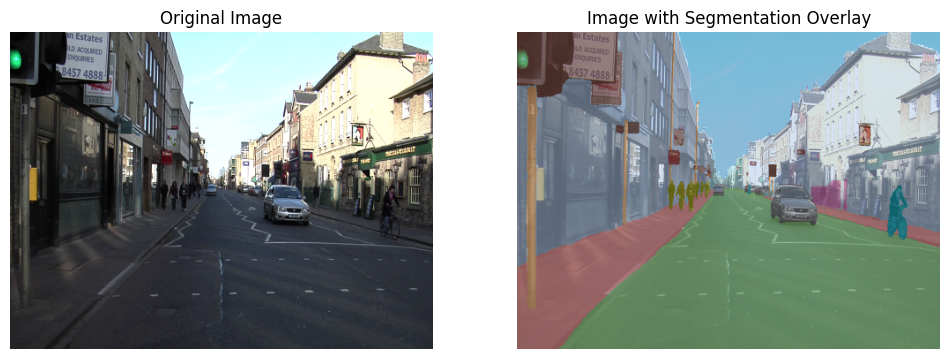

In [10]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled'])

image, mask = dataset[6] # get some sample
visualize(
    image=image,
    mask=mask,
)

In [ ]:
# mask.shape
mask.squeeze().shape

(360, 480, 12)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [11]:
import albumentations as albu

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [12]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [13]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),  # 0 for BORDER_CONSTANT

        # Use border_mode=0 for constant padding
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0, value=0),  # Black border
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),  # Replacing IAAAdditiveGaussianNoise with GaussNoise
        albu.Perspective(p=0.5),  # Replacing IAAPerspective with Perspective

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),  # Replacing IAASharpen with Sharpen
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled'],
)

# same image with different random transforms
for i in range(5):
    image, mask = augmented_dataset[6]
    visualize(image=image, mask=mask)

## Create model and train

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
# Import the necessary libraries
import segmentation_models_pytorch as smp

# Set up the parameters
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']
ACTIVATION = 'softmax2d'  # Use sigmoid  if doing one-single-class segmentation
# Define the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create FPN model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,  # Use 'imagenet' pretrained weights for encoder initialization
    classes=len(CLASSES),  # Number of classes in your dataset
    activation=ACTIVATION,  # Activation function for the output
    in_channels=3  # Model input channels (1 for gray-scale images, 3 for RGB, etc.)
)

# Get preprocessing function for the encoder
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocessing_fn = get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)


In [ ]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
from segmentation_models_pytorch import utils
loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 50):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Computer vision/segmentation/best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('/content/drive/MyDrive/Computer vision/segmentation/best_model.pth')

<ipython-input-41-fa6e12488f83>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('/content/drive/MyDrive/Computer vision/segmentation/best_model.pth'

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(valid_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 101/101 [01:11<00:00,  1.42it/s, dice_loss - 0.9354, iou_score - 0.01972]


## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        # ground_truth_mask=gt_mask,
        mask=pr_mask
    )

<ipython-input-7-eec905a1153f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', mask.shape[2])


ValueError: operands could not be broadcast together with shapes (360,480,3) (12,384,3) 

In [ ]:
import cv2
import torch
import numpy as np

# Load the trained model
best_model = torch.load('/content/drive/MyDrive/Computer vision/segmentation/best_model.pth')
best_model.eval()

# Define the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the video
video_path = '/content/drive/MyDrive/Computer vision/segmentation/test.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
output_path = '/content/drive/MyDrive/Computer vision/segmentation/egmented_video.mp4'

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Function to preprocess the frame for the model
def preprocess_frame(frame):
    # Resize the frame if necessary to match training dimensions
    frame_resized = cv2.resize(frame, (320, 320))
    # Normalize and transpose to match model input shape
    frame_normalized = frame_resized / 255.0
    frame_transposed = np.transpose(frame_normalized, (2, 0, 1))
    # Convert to tensor and add batch dimension
    return torch.from_numpy(frame_transposed).float().to(DEVICE).unsqueeze(0)

# Function to post-process the predicted mask
def postprocess_mask(mask, original_shape):
    # Squeeze to remove batch dimension and convert to NumPy array
    mask = mask.squeeze().cpu().numpy().round()
    # Resize mask back to original frame size
    mask_resized = cv2.resize(mask, (original_shape[1], original_shape[0]))
    # Convert mask to binary (0 or 255) for visualization
    return (mask_resized * 255).astype(np.uint8)

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    x_tensor = preprocess_frame(frame)

    # Make prediction
    with torch.no_grad():
        pr_mask = best_model.predict(x_tensor)

    # Post-process the predicted mask
    segmented_mask = postprocess_mask(pr_mask, frame.shape[:2])

    # Apply the mask directly onto the original frame
    # Make the segmented areas appear in red (BGR: (0, 0, 255))
    frame[segmented_mask > 128] = (0, 0, 255)

    # Write the frame to the output video
    out.write(frame)

# Release video objects
cap.release()
out.release()

print(f'Segmented video saved as {output_path}')


Mounted at /content/drive


<ipython-input-43-acc5836e92da>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('/content/drive/MyDrive/Computer vision/segmentation/best_model.pth'

Segmented video saved as /content/drive/MyDrive/Computer vision/segmentation/egmented_video.mp4
